### Via `RRT-Star` Inverse Kinematic

In [6]:
import mujoco,cv2,os
import numpy as np
import mediapy as media
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append('../../')
from model.mujoco_parser import MuJoCoParserClass
from model.rrt import RapidlyExploringRandomTreesStarClass
from model.util import rpy2r,get_interp_const_vel_traj,kernel_levse,pr2t,t2p,t2r, sample_xyzs
from model.grpp import GaussianRandomPathClass
from scipy.spatial.distance import cdist
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("networkx version:[%s]"%(nx.__version__))
print ("MuJoCo version:[%s]"%(mujoco.__version__))

networkx version:[3.1]
MuJoCo version:[2.3.4]


In [11]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects in a row
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.55,1.65],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0.18,0,0.8])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_body:[52]
geom_names:['floor', None, None, None, None, None, 'ur_shoulder_link_collision', None, None, None, None, 'ur_upper_arm_link_1_collision', 'ur_upper_arm_link_2_collision', None, None, None, None, 'ur_forearm_link_1_collision', 'ur_forearm_link_2_collision', None, None, None, 'ur_wrist_1_link_collision', None, None, None, 'ur_wrist_2_link_1_collision', 'ur_wrist_2_link_2_collision', None, 'ur_wrist_3_link_collision', 'ur_tcp_link_collision', 'camera_mount_collision', 'camera_mounted_gear_collision', 'ur_rg2_gripper_base_link_collision', 'camera_center_collision', 'ur_rg2_gripper_finger1_finger_link_collision', 'ur_rg2_gripper_finger1_inner_knuckle_link_collision', 'ur_rg2_gripper_finger1_finger_tip_link_collision', 'ur_rg2_gripper_finger2_finger_link_collision', 'ur_rg2_gripper_finger2_inner_knuckle_link_collision', 'ur_rg2_gripper_finger2_finger_tip_link_collision', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder

### Indexing about `Jacobian, Kinematics, Dynamics` in mujoco engine

### Get gripper joint indexes

In [12]:
joint_names = env.rev_joint_names[:6]
idxs_forward = [env.model.joint(joint_name).qposadr[0] for joint_name in env.joint_names[:6]]
idxs_jacobian = [env.model.joint(joint_name).dofadr[0] for joint_name in env.joint_names[:6]]
list1, list2 = env.ctrl_joint_idxs, idxs_forward
idxs_step = []
for i in range(len(list2)):
    if list2[i] in list1:
        idxs_step.append(list1.index(list2[i]))
        
gripper_joint_idxs = []

for gripper_idx in env.rev_joint_idxs:
    if gripper_idx not in env.idxs_forward:
        gripper_joint_idxs.append(gripper_idx)
print(f"Gripper joint idxs: {gripper_joint_idxs}")

Gripper joint idxs: [6, 7, 8, 9, 10, 11]


In [13]:
init_q = [-1.570521656666891, -2.311883111993307, 2.1441715399371546, 1.73920385419812, 0.7853929996490479, -1.5711215178119105]
q_close_grasp = [-0.03, -0.0273, -0.03, 0.03, 0.0273, 0.03]

### Get initial and final poses by solving IK

In [15]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset
q_rev_init = env.get_q(joint_idxs=idxs_jacobian) # get initial joint position

# Close gripper (prismatic joints)
env.forward(q=np.array([0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.idxs_forward)
env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)

# Set IK for the initial pose
ik_body_name = 'tcp_link'
p_trgt,R_trgt = np.array([0.65,-0.3,0.95]),rpy2r(np.array([-180,0,90])*np.pi/180.0)
T_trgt_init = pr2t(p_trgt,R_trgt)
env.forward(q=q_rev_init,joint_idxs=env.idxs_forward)
while (env.tick < 10000) and env.is_viewer_alive():
    q,err = env.onestep_ik(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
        joint_idxs=idxs_jacobian,stepsize=1,eps=1e-1,th=10*np.pi/180.0)
    env.render(render_every=1)
    if np.linalg.norm(err) < 1e-6: break
q_init = env.get_q(joint_idxs=idxs_jacobian)

# Set IK for the final pose
ik_body_name = 'tcp_link'
p_trgt,R_trgt = np.array([0.8,0.0,1.05]),rpy2r(np.array([-180,0,90])*np.pi/180.0)
T_trgt_final = pr2t(p_trgt,R_trgt)
env.forward(q=q_rev_init,joint_idxs=env.idxs_forward)
env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)
while (env.tick < 10000) and env.is_viewer_alive():
    q,err = env.onestep_ik(
        body_name=ik_body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
        joint_idxs=env.rev_joint_idxs,stepsize=1,eps=1e-1,th=10*np.pi/180.0)
    env.render(render_every=1)
    if np.linalg.norm(err) < 1e-6: break
q_final = env.get_q(joint_idxs=idxs_jacobian)

# Close viewer
env.close_viewer()
print ("Done.")

Done.


### RRT

In [24]:
RRT = RapidlyExploringRandomTreesStarClass(
    name='RRT-Star-Panda',
    point_min=env.joint_ranges[idxs_forward][:,0],
    point_max=env.joint_ranges[idxs_forward][:,1],
    goal_select_rate=0.75,
    steer_len_max=np.deg2rad(45),search_radius=np.deg2rad(120),norm_ord=2,
    n_node_max=5000,TERMINATE_WHEN_GOAL_REACHED=False,SPEED_UP=True)
# Set root and goal points
RRT.init_rrt_star(point_root=q_init,point_goal=q_final)
print ("[%s] ready."%(RRT.name))

[RRT-Star-Panda] ready.


### Define `is_point_feasible` and `is_point_to_point_connectable`

In [25]:
def is_point_feasible(env,point_sample):
    q_bu = env.get_q(joint_idxs=env.idxs_jacobian)  # q_backup
    env.forward(q=point_sample,joint_idxs=env.idxs_forward)
    p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(must_include_prefix='ur_', must_exclude_prefix=None)
    # env.forward(q=q_bu,joint_idxs=idxs_forward)
    if len(p_contacts) == 1: # exclude about rg2 gripper tip contact.
        # print(geom1s, geom2s)
        return True
    else:
        # print(f"Collision Detect! {geom1s} and {geom2s} were collided.")
        return False
def is_point_to_point_connectable(env,point_fr,point_to):
    for alpha in np.linspace(0,1,5):
        point_check = alpha*point_fr + (1-alpha)*point_to
        if not is_point_feasible(env,point_check):
            return False
    return True
print ("Ready.")

Ready.


### RRT Loop

In [28]:
# Init viewer (for debugging purposes)
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.update_viewer(VIS_JOINT=True,jointlength=0.5,jointwidth=0.1,jointrgba=[0.2,0.6,0.8,0.6])
env.reset() # reset

# Zero-pose with gripper open
env.forward(q=np.array([0,0,0,0,90,0])*np.pi/180.0,joint_idxs=env.idxs_forward)
env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)

node_min = None
eef_points = []

GOAL_REACHED_FLAG = True
while (RRT.get_n_node() <= RRT.n_node_max) and RRT.increase_loop_cnt() and env.is_viewer_alive():
    
    # Randomly sample a point 
    while True:
        if np.random.rand() <= RRT.goal_select_rate: point_sample = RRT.point_goal 
        else: point_sample = RRT.sample_point() # random sampling
        if is_point_feasible(env,point_sample): break

    # Get the nearest node ('node_nearest') to 'point_sample' from the tree
    node_nearest = RRT.get_node_nearest(point_sample)
    
    # Steering towards 'point_sample' to get 'point_new'
    point_new,cost_new = RRT.steer(node_nearest,point_sample)
    if point_new is None: continue # if the steering point is feasible

    # Rewiring
    if is_point_feasible(env,point_new) \
        and is_point_to_point_connectable(
        env,RRT.get_node_point(node_nearest),point_new):
        
        # Assign 'node_min' and initialize 'cost_min' with 'cost_new'
        node_min = node_nearest.copy()
        cost_min = cost_new
        
        # Select a set of nodes near 'point_new' => 'nodes_near'
        nodes_near = RRT.get_nodes_near(point_new)

        # For all 'node_near' find 'node_min'
        for node_near in nodes_near:
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            if is_point_to_point_connectable(env,point_near,point_new):
                cost_prime = cost_near + RRT.get_dist(point_near,point_new)
                if cost_prime < cost_min:
                    cost_min = cost_near + RRT.get_dist(point_near,point_new)
                    node_min = node_near
                    
        # Add 'node_new' and connect it with 'node_min'
        node_new = RRT.add_node(point=point_new,cost=cost_min,node_parent=node_min)
        
        # New node information for rewiring
        point_new,cost_new = RRT.get_node_point_and_cost(node_new)
        p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(
            must_exclude_prefix='obj_')

        env.forward(q=point_new,joint_idxs=env.idxs_forward)
        env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)

        # Rewire
        for node_near in nodes_near:
            if node_near == 0: continue
            if RRT.get_node_parent(node_near) == node_new: continue
            point_near,cost_near = RRT.get_node_point_and_cost(node_near)
            cost_check = cost_new+RRT.get_dist(point_near,point_new)
            if (cost_check < cost_near) and \
                is_point_to_point_connectable(env,point_near,point_new):
                # print (" [%d] rewired from [%d] to [%d]"%(node_near,RRT.get_node_parent(node_near),node_new))
                RRT.replace_node_parent(node=node_near,node_parent_new=node_new)

    # Re-update cost of all nodes
    RRT.update_nodes_cost(node_source=node_min,VERBOSE=False)
    if ((RRT.get_n_node()%(RRT.n_node_max//10)) == 0):
        RRT.update_nodes_cost(node_source=0,VERBOSE=False)
        env.render(render_every=1)

    # Debug plot
    DEBUG_PLOT = True
    if DEBUG_PLOT:
        # Get contact information
        p_contacts,f_contacts,geom1s,geom2s = env.get_contact_info(
            must_exclude_prefix='obj_')
        # Render contact informations
        for (p_contact,f_contact,geom1,geom2) in zip(p_contacts,f_contacts,geom1s,geom2s):
            f_norm = np.linalg.norm(f_contact)
            f_uv = f_contact / (f_norm+1e-8)
            f_len = 0.3 # f_norm*0.05
            env.plot_arrow(p=p_contact,uv=f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                        label='')
            env.plot_arrow(p=p_contact,uv=-f_uv,r_stem=0.01,len_arrow=f_len,rgba=[1,0,0,1],
                        label='')
            label = 'Contact point' # '[%s]-[%s]'%(geom1,geom2)
            env.plot_sphere(p=p_contact,r=0.02,rgba=[1,0.2,0.2,1],label=label)

        eef_point = env.get_p_body('tcp_link')
        eef_points.append(eef_point)
        for p in eef_points: env.plot_sphere(p,r=0.005,rgba=[0.2,0.2,0.2,0.5],label='')

        env.forward(q=point_new,joint_idxs=env.idxs_forward)
        env.forward(q=q_close_grasp, joint_idxs=gripper_joint_idxs)
        env.render(render_every=1)
        
    # Debug print
    dist_to_goal = RRT.get_dist_to_goal()
    cost_goal = RRT.get_cost_goal()
    if ((RRT.get_n_node()%(RRT.n_node_max//20)) == 0) or (RRT.get_n_node()==1):
        print ("[%d/%d] cost_goal:[%.3f]"%
               (RRT.get_n_node(),RRT.n_node_max,cost_goal))
    if (not GOAL_REACHED_FLAG) and (dist_to_goal < 1e-6):
        GOAL_REACHED_FLAG = True
        print ("[%d/%d] First goal reached. cost_goal:[%.3f]"%
               (RRT.get_n_node(),RRT.n_node_max,cost_goal))
    
    # Terminate condition
    if (dist_to_goal < 1e-6) and RRT.TERMINATE_WHEN_GOAL_REACHED:
        print ("Goad reached. n_node:[%d] dist_to_goal:[%.4f]"%
               (RRT.get_n_node(),dist_to_goal))
        break
    
# Close viewer
env.close_viewer()
print ("Done.")

[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]
[1/5000] cost_goal:[inf]


### Print `RRT*` results

In [10]:
path_to_goal,path_node_list = RRT.get_path_to_goal()
for node_idx,node in enumerate(path_node_list):
    print ("[%d/%d] node:[%d] point:%s cost:[%.2f]"%
           (node_idx,len(path_node_list),node,RRT.get_node_point(node),
            RRT.get_node_cost(node)))

[0/4] node:[0] point:[-1.04 -1.15  2.02 -0.87  0.53 -0.  ] cost:[0.00]
[1/4] node:[6] point:[-0.04 -1.07  1.87 -0.78  1.37  0.13] cost:[1.33]
[2/4] node:[9] point:[ 0.35 -1.01  1.78 -0.77  1.92  0.  ] cost:[2.03]
[3/4] node:[11] point:[ 0.35 -1.01  1.78 -0.77  1.92  0.  ] cost:[2.03]


### Animate `RRT*` result

In [11]:
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=80,distance=2.5,elevation=-30,lookat=[0,0,1.5])
env.reset()
L = path_to_goal.shape[0]
imgs = []
for tick in range(L):
    q = path_to_goal[tick,:]
    env.forward(q=q,joint_idxs=env.idxs_forward)
    for _ in range(20): env.render() # animate little longer
    imgs.append(env.grab_image())
env.close_viewer() # close viewer
print ("Done.")

Done.


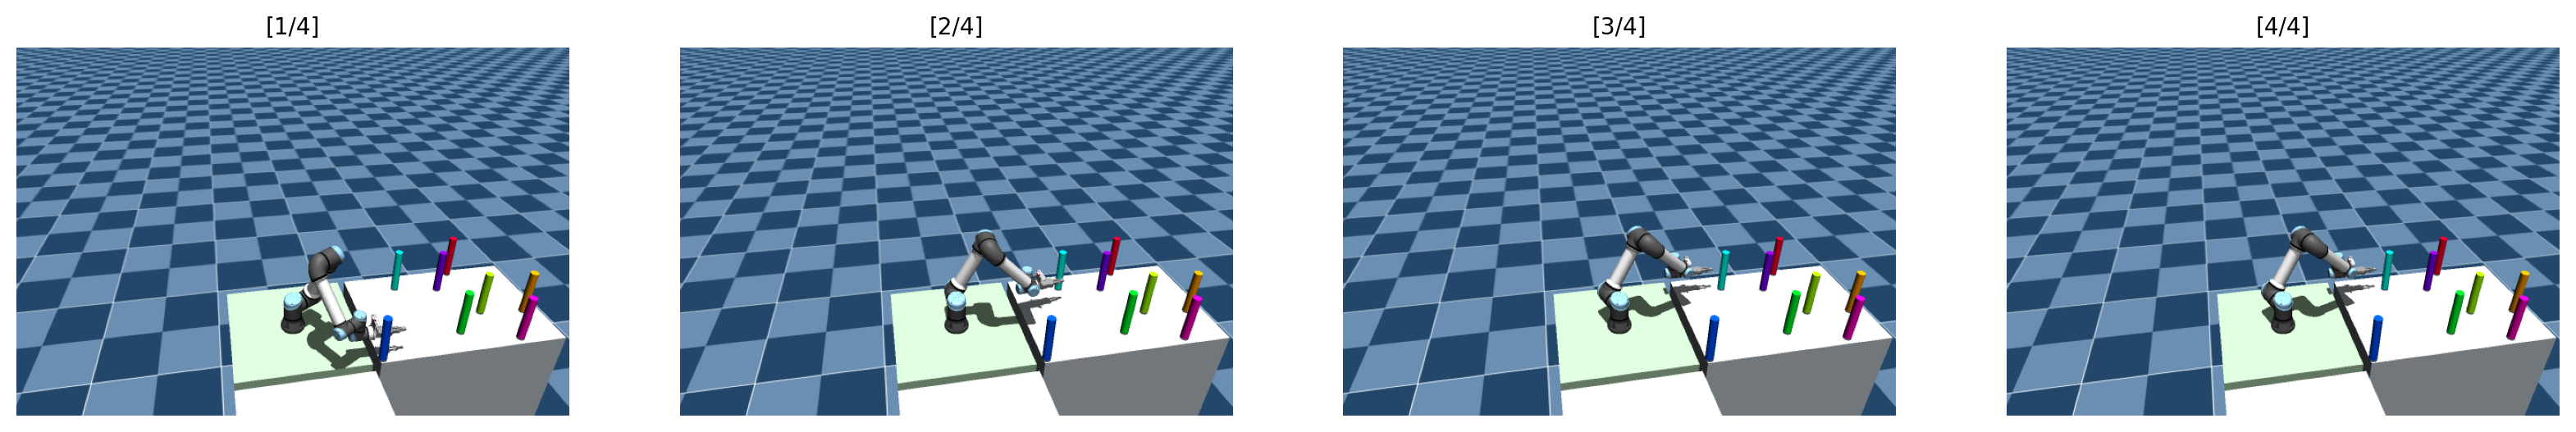

Done.


In [12]:
plt.figure(figsize=(20,5))
for i_idx in np.linspace(0,len(imgs)-1).astype(np.int32):
    plt.subplot(1, len(imgs), i_idx+1)
    plt.imshow(cv2.resize(imgs[i_idx],(600,400)))
    plt.axis('off'); plt.title('[%d/%d]'%(i_idx+1,len(imgs)),fontsize=10)
plt.show()
print ("Done.")

### Plot joint positions

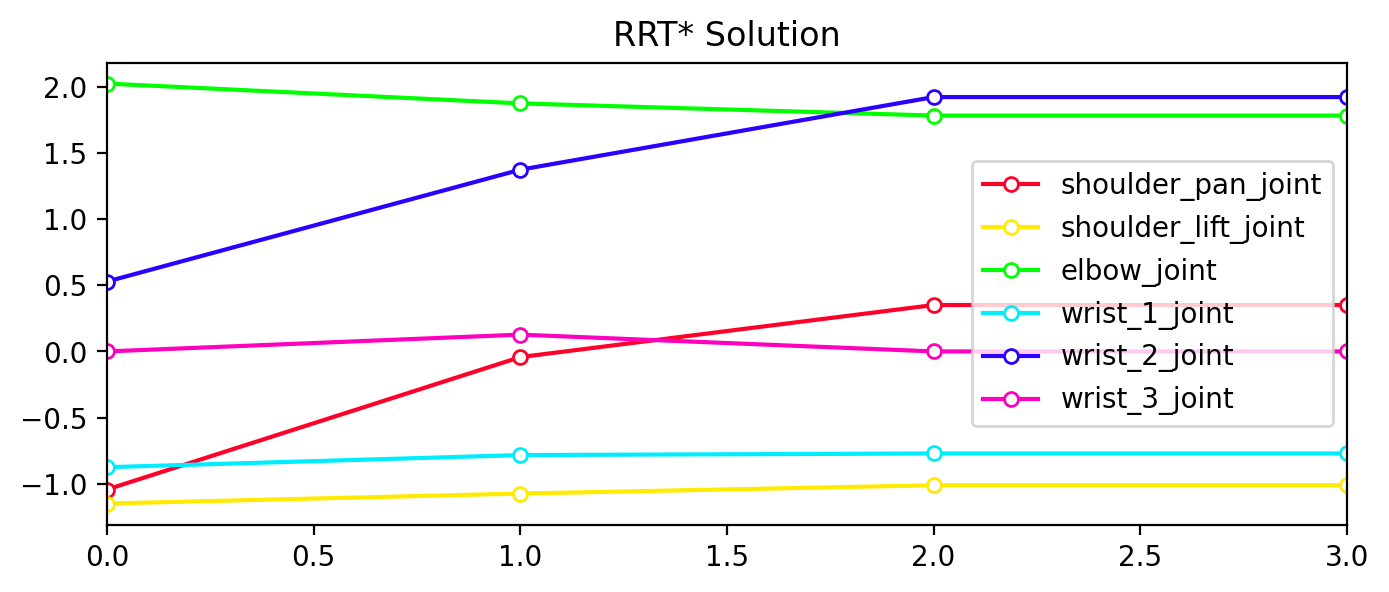

In [13]:
plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(path_to_goal[:,d_idx],
             '-',marker='o',mec=color,mfc='w',ms=5,color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.title("RRT* Solution")    
plt.xlim(0,L-1); plt.legend(fontsize=10); plt.show()

### Compute `qs_interp`

In [14]:
# Configuration
qvel_rad = np.deg2rad(90) # desired joint velocity (deg/sec)
HZ = 100
times_interp,qs_interp = get_interp_const_vel_traj(path_to_goal,vel=qvel_rad,HZ=HZ,ord=np.inf)
L_interp = qs_interp.shape[0]
print ("qvel_deg:[%.2f]deg/sec L_interp:[%d] HZ:[%d] time_max:[%.2f]sec"%
       (np.rad2deg(qvel_rad),L_interp,HZ,times_interp[-1]))

qvel_deg:[90.00]deg/sec L_interp:[98] HZ:[100] time_max:[0.99]sec


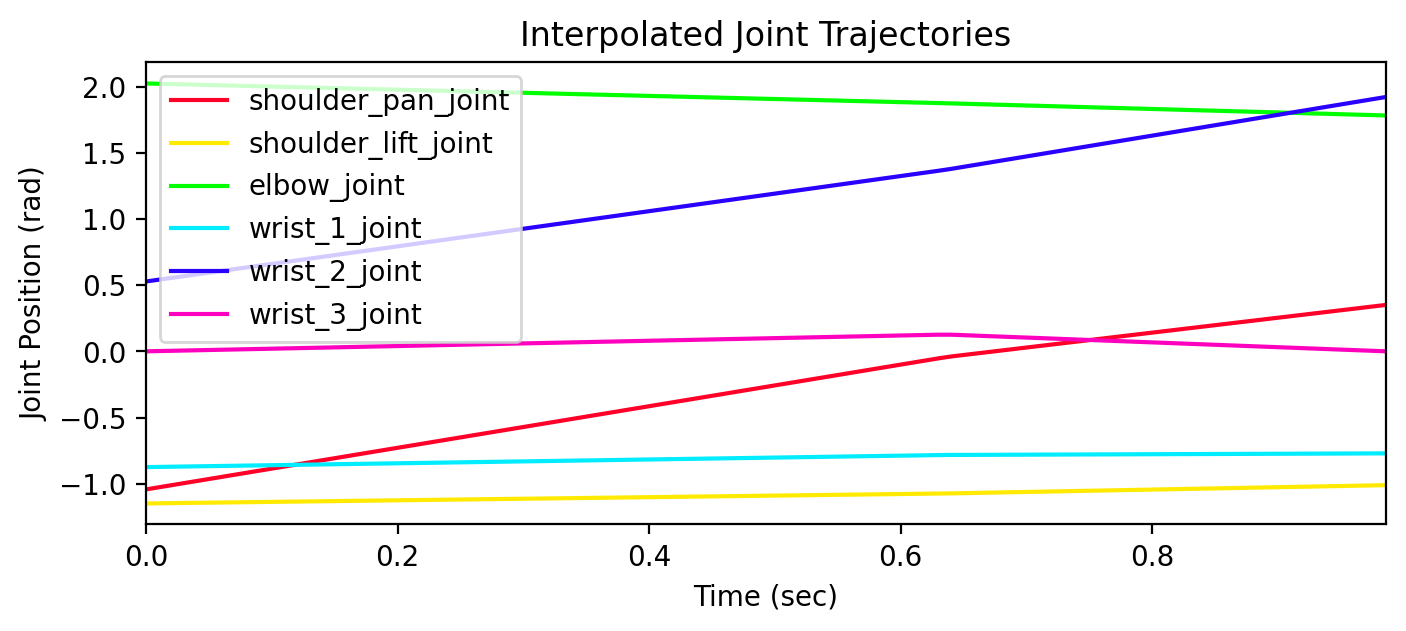

In [15]:
plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(times_interp,qs_interp[:,d_idx],'-',color=color,
             label='%s'%(env.rev_joint_names[d_idx]))
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Interpolated Joint Trajectories")
plt.xlim(0,times_interp[-1]); plt.legend(fontsize=10); plt.show()

### Animate interpolated RRT* solution (`times_interp` and `qs_interp`)

In [16]:
# Animate
env.init_viewer(viewer_title='Spawn Objects',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36])
env.reset()
for tick in range(L_interp):
    q = qs_interp[tick,:]
    env.forward(q=q,joint_idxs=env.idxs_forward)
    env.render(); 
    if not env.is_viewer_alive(): break
for tick in range(500): # final pose animate
    env.render(); 
    if not env.is_viewer_alive(): break
env.close_viewer() # close viewer
print ("Done.")

Pressed ESC
Quitting.
Done.


### Smooth using `GRP`

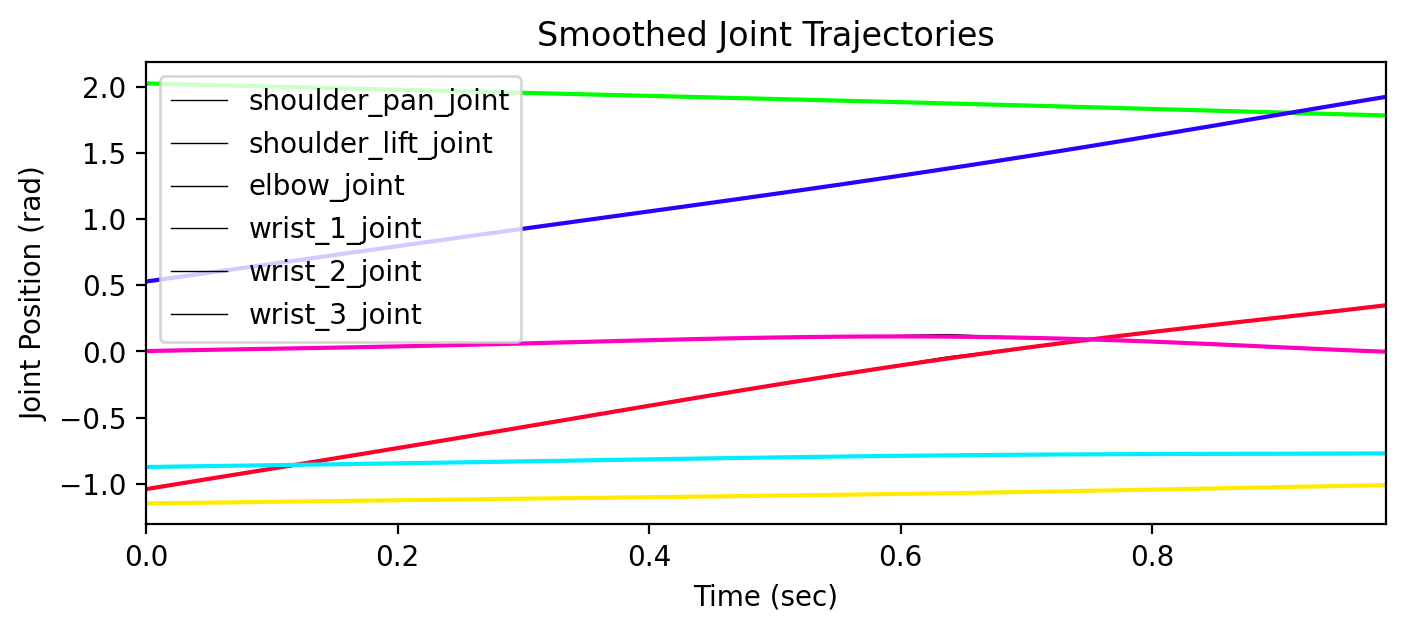

In [17]:
G = GaussianRandomPathClass(name='LGRP',kernel=kernel_levse)
G.set_data(t_anchor    = times_interp.reshape((-1,1)),
           x_anchor    = qs_interp,
           l_anchor    = np.ones((len(times_interp),1)),
           t_test      = times_interp.reshape((-1,1)),
           l_test      = np.ones((len(times_interp),1)),
           hyp_mean    = {'g':1.0,'l':1.0,'w':1e-6},
           hyp_var     = {'g':1.0,'l':1.0,'w':1e-6},
           APPLY_EPSRU = False
          )
qs_smooth = G.mean_test
# Plot smoothed trajectories
plt.figure(figsize=(8,3))
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,RRT.dim)])
for d_idx in range(RRT.dim):
    color=colors[d_idx,:]
    plt.plot(times_interp,qs_interp[:,d_idx],'-',color='k',lw=1/2,
             label='%s'%(env.rev_joint_names[d_idx]))
    plt.plot(times_interp,qs_smooth[:,d_idx],'-',color=color)
plt.xlabel('Time (sec)'); plt.ylabel('Joint Position (rad)')
plt.title("Smoothed Joint Trajectories")
plt.xlim(0,times_interp[-1]); plt.legend(fontsize=10); plt.show()

### Animate smoothed trajectories

In [20]:
# Animate
env.init_viewer(viewer_title='Smoothed RRT-Star Trajectory',viewer_width=1200,viewer_height=800,viewer_hide_menus=True)
env.update_viewer(azimuth=0.0,distance=3.5,elevation=-60,lookat=[0.4,0.05,0.36])
env.reset()
frames = []
for tick in range(L_interp): # HZ
    q = qs_smooth[tick,:]
    env.forward(q=q,joint_idxs=env.idxs_forward)
    env.plot_T(t2p(T_trgt_init),t2r(T_trgt_init),PLOT_AXIS=True,axis_len=0.1,axis_width=0.01)
    env.plot_T(t2p(T_trgt_final),t2r(T_trgt_final),PLOT_AXIS=True,axis_len=0.1,axis_width=0.01)
    env.render()
    if (tick % (HZ//20)) == 0: frames.append(cv2.resize(env.grab_image(),(600,400)))
    if not env.is_viewer_alive(): break
for tick in range(100): # animate final pose for a while
    env.plot_T(t2p(T_trgt_init),t2r(T_trgt_init),PLOT_AXIS=True,axis_len=0.1,axis_width=0.01)
    env.plot_T(t2p(T_trgt_final),t2r(T_trgt_final),PLOT_AXIS=True,axis_len=0.1,axis_width=0.01)
    env.render()
    if tick <= 20: frames.append(cv2.resize(env.grab_image(),(600,400)))
    if not env.is_viewer_alive(): break
env.close_viewer() # close viewer
print ("Done.")

Pressed ESC
Quitting.
Done.


In [19]:
media.show_video(frames, fps=20)